For this assignment I have chosen the Titanic dataset, because it sounded the most interesting. I will first load it and display the list of passengers:

In [5]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Now I will do some data clean-up: drop the Cabin column (too many items missing) and fill in the missing Ages and Embarkation statuses.

In [6]:
# Drop 'Cabin'
df = df.drop(columns=['Cabin'])

# Fill missing 'Age' with the median (safe syntax)
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing 'Embarked' with the mode (safe syntax)
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Drop any duplicate rows
df = df.drop_duplicates()

Now time for some final sanity checks for inconsistent data:

In [26]:

# Double check for missing values
print(df.isnull().sum())

print(df['Embarked'].unique())  # should be 'C', 'Q', 'S'

# Check for negative values in 'Fare' and 'Age'
print(df[df['Fare'] < 0])  # shouldn't happen
print(df[df['Age'] < 0])   # also shouldn't happen

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
['S' 'C' 'Q']
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []
Empty DataFrame
Columns: [PassengerId, Survived, Pclass, Name, Sex, Age, SibSp, Parch, Ticket, Fare, Embarked]
Index: []


All the data looks right! Time to look for some outliers in age and fare:

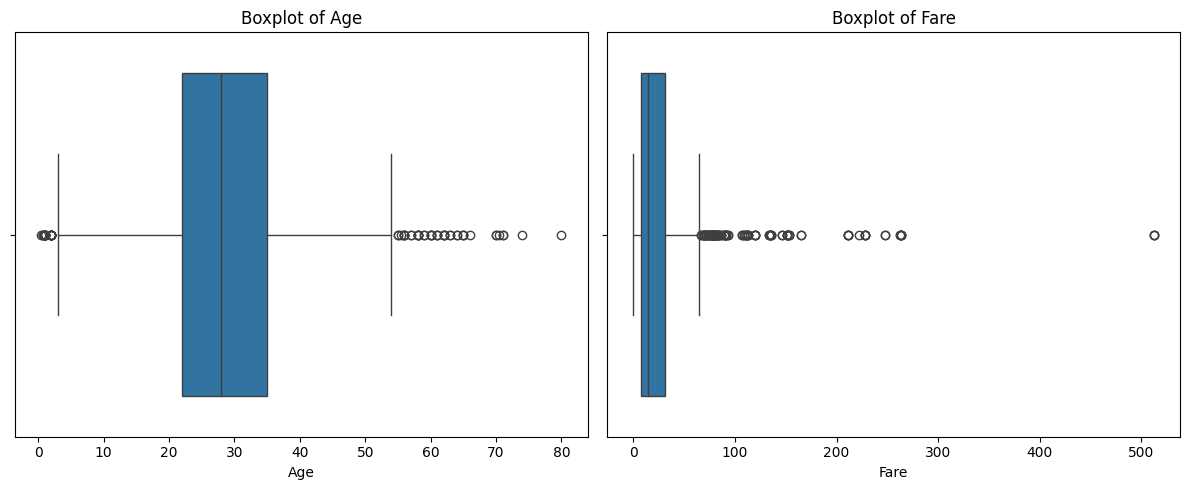

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplots to visualize outliers
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=df['Age'])
plt.title('Boxplot of Age')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['Fare'])
plt.title('Boxplot of Fare')

plt.tight_layout()
plt.show()


Outliers can be seen in both Fare and Age. However, these values are consistent with real-world expectations (wealthy passengers or elderly individuals). Therefore, we won't remove any rows, but we might apply a transformation such as log scaling later during modeling.



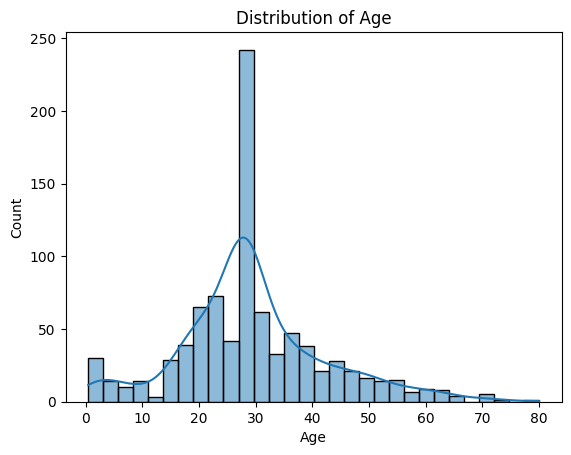

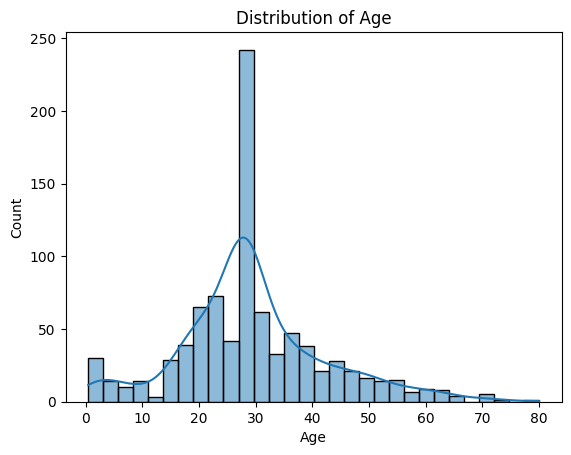

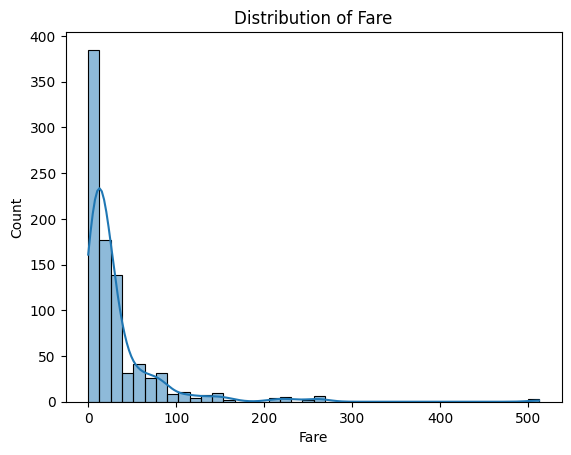

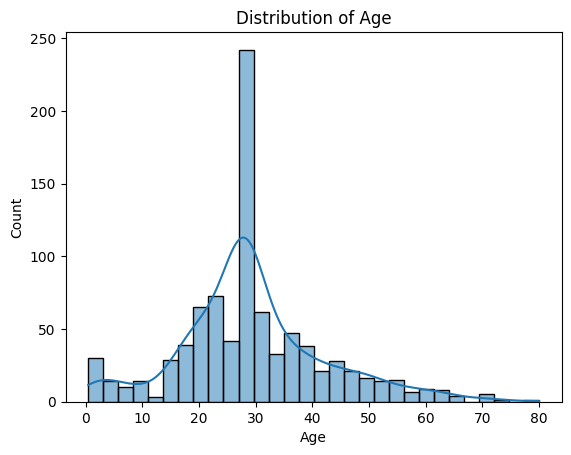

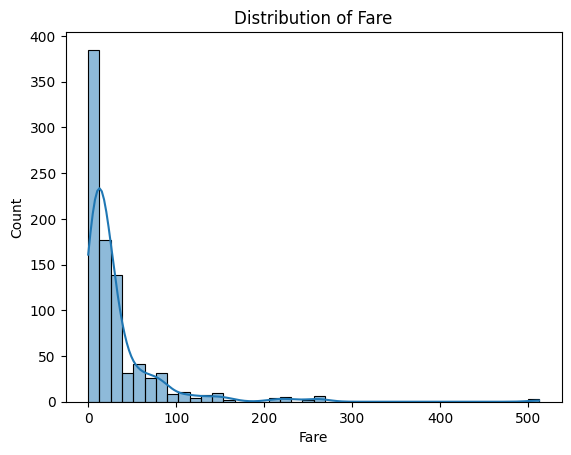

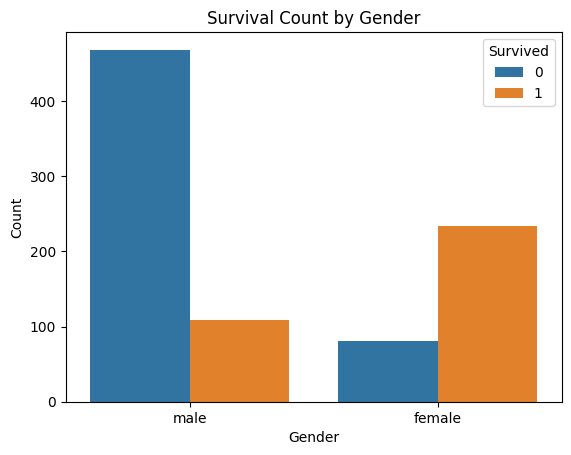

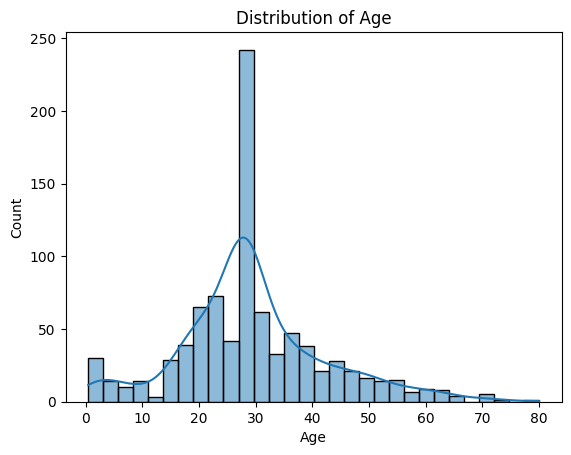

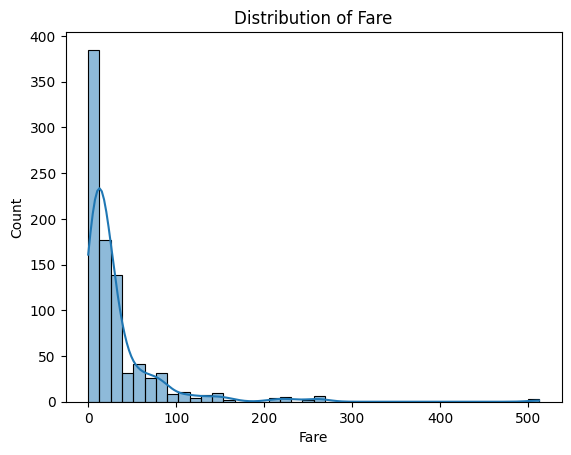

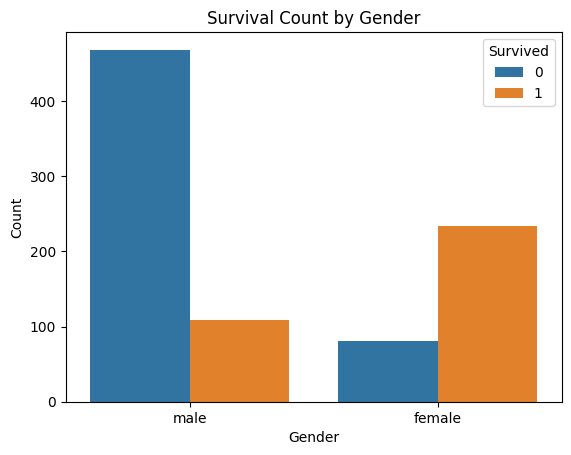

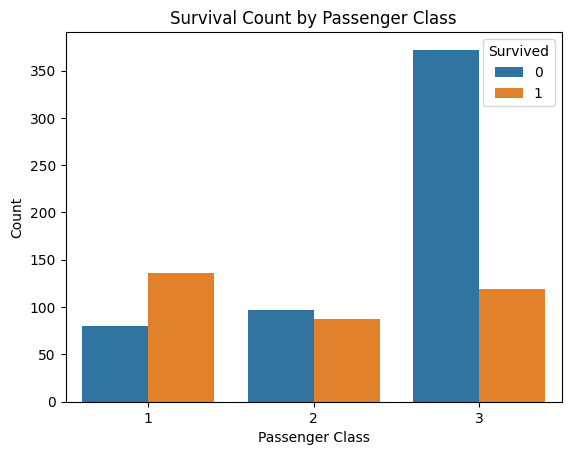

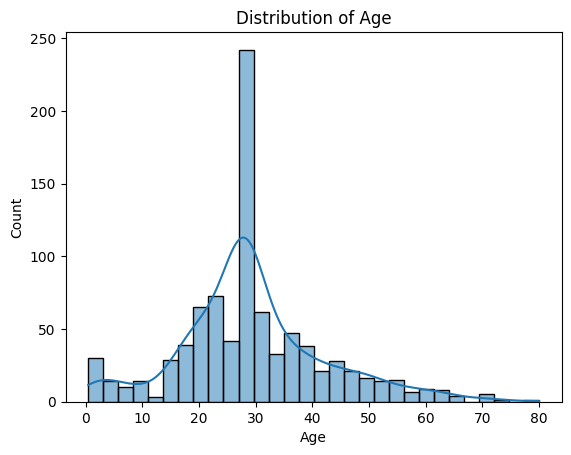

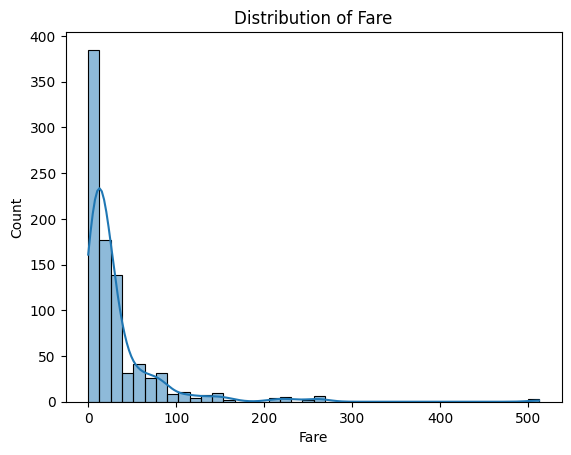

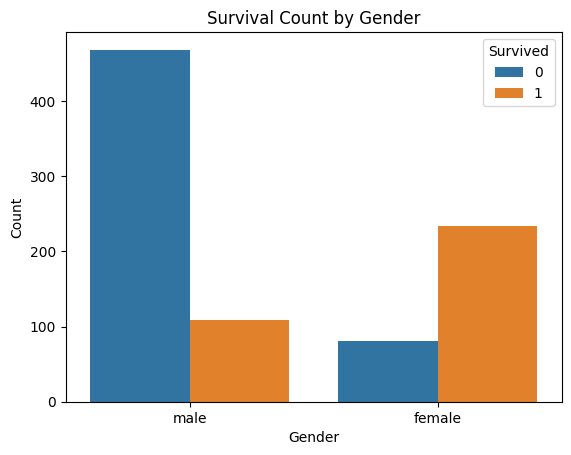

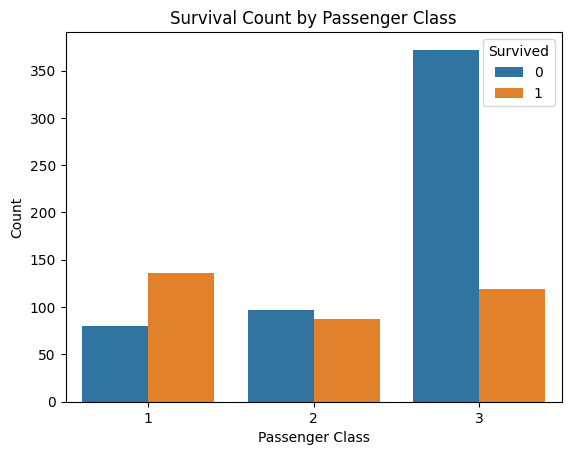

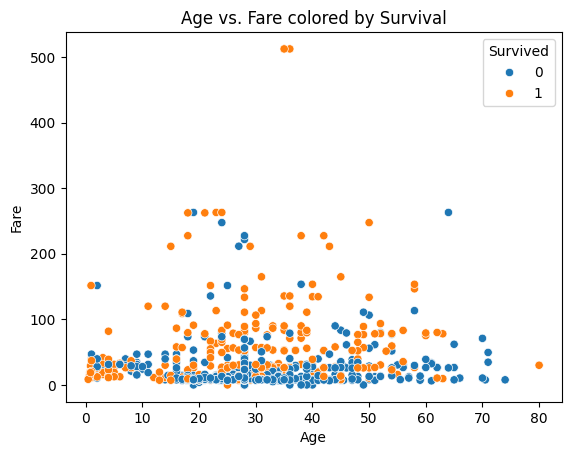

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Distribution of Age
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# 2. Distribution of Fare
sns.histplot(df['Fare'], kde=True, bins=40)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Count')
plt.show()

# 3. Survival count by gender
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

# 4. Survival by passenger class
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival Count by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', loc='upper right')
plt.show()

# 5. Age vs. Fare colored by survival
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=df)
plt.title('Age vs. Fare colored by Survival')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.legend(title='Survived')
plt.show()


### Exploratory Data Analysis (EDA)

Most passengers are in their 20s–30s. There are also some infants and older adults, but nothing too weird or extreme.

Fare is heavily skewed — most people paid under \$50, but a few went way over \$500. 

Survival patterns stood out:
- Women had much higher survival rates than men: lines up with “women and children first”.
- People in 1st class were way more likely to survive compared to 3rd class.

When looking at age vs fare, survivors leaned toward higher fares, which makes sense given the class difference. There's also a small but clear cluster of younger, wealthier survivors.

### Future modeling

This gave us a pretty good idea of what features will matter later. Gender and class are clearly important, so I’ll definitely use them in classification models. Since `Fare` is very skewed, we might log-transform it to make things more stable. Also, the relationships don’t look very linear, so tree-based models might work better than linear ones.

Since the relationships in the data don’t look very linear and there’s a mix of numeric and categorical features, the bets approach seems to be with tree-based models like Decision Trees or Random Forests. They usually perform better in this kind of setup and don’t need as much preprocessing.



# Deliverable 2

Now I will add two new features to improve the dataset for modeling:

Title extraction from Name: This feature pulls out the passenger's title (Mr, Mrs, Miss, etc.) from the Name column. Titles often reflect social status, which can affect survival odds.

FamilySize: This feature combines the number of siblings/spouses (`SibSp`) and parents/children (`Parch`) traveling with the passenger, plus one (the passenger themselves). Family size can influence survival, as people traveling alone or in large groups may have different outcomes.

These engineered features should help the model better capture important patterns in the data.

In [10]:
# Add Title feature by extracting from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.') # this regex captures the title after the comma and before the period
print(df['Title'].value_counts())  # quick check of extracted titles

# Add FamilySize feature
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
print(df[['SibSp', 'Parch', 'FamilySize']].head())  # quick check

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64
   SibSp  Parch  FamilySize
0      1      0           2
1      1      0           2
2      0      0           1
3      1      0           2
4      0      0           1


The new features look good!

Title: Most passengers are Mr, Miss, Mrs, or Master, but there are also rare titles like Dr, Rev, and nobility. These can help the model pick up on social status and its effect on survival.

FamilySize: Most people traveled alone or with one other person, but there are some larger families. This feature will help the model understand group survival patterns.

Both features add useful information for future modeling.

## Regression Modelling to determine survival

I'll build two regression models to predict passenger fare using the new features and other relevant columns. I'll use Linear Regression as a baseline, and Ridge Regression to see if regularization helps.

For both models, I'll use Pclass, Sex, Age, FamilySize, and Title. The goal is to see how well these features explain the variation in fare prices.

In [15]:
from numpy import log1p
from sklearn.calibration import LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


# Features for regression
features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Title']
X = df[features]
X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0
df['LogFare'] = log1p(df['Fare'])
y_log = df['LogFare'] # Log-transform Fare to stabilize for variance
le_title = LabelEncoder()
X['Title'] = le_title.fit_transform(X['Title'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Linear Regression on log(Fare)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_lin = linreg.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
print(f'Linear MSE: {mse_lin:.10f}')

# Ridge Regression on log(Fare)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge MSE: {mse_ridge:.10f}')

Linear MSE: 0.2883397480
Ridge MSE: 0.2882901028


/var/folders/6b/mkrflm9150qd0xn0m2ny51wm0000gn/T/ipykernel_64433/3679705116.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0
/var/folders/6b/mkrflm9150qd0xn0m2ny51wm0000gn/T/ipykernel_64433/3679705116.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Title'] = le_title.fit_transform(X['Title'])


Both Linear Regression and Ridge Regression produced very similar MSE values on the log-transformed Fare target.

This indicates that Ridge did not significantly improve model performance over Linear. The log transformation however helped reduce the impact of outliers and skewness in Fare, resulting in lower and more stable error values.

In [54]:
# Cross-validation for Linear and Ridge Regression on log-transformed Fare
from sklearn.model_selection import cross_val_score

# Features and target
features = ['Pclass', 'Sex', 'Age', 'FamilySize', 'Title']
X = df[features]
X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0

le_title = LabelEncoder()
X['Title'] = le_title.fit_transform(X['Title'])
y_log = df['LogFare']

# Linear Regression cross-validation (negative MSE)
linreg = LinearRegression()
cv_mse_lin = cross_val_score(linreg, X, y_log, cv=5, scoring='neg_mean_squared_error')
print('Linear CV MSE:', -cv_mse_lin.mean())

# Ridge Regression cross-validation (negative MSE)
ridge = Ridge(alpha=1.0)
cv_mse_ridge = cross_val_score(ridge, X, y_log, cv=5, scoring='neg_mean_squared_error')
print('Ridge CV MSE:', -cv_mse_ridge.mean())

Linear CV MSE: 0.35756922346493347
Ridge CV MSE: 0.35755141081088115


/var/folders/6b/mkrflm9150qd0xn0m2ny51wm0000gn/T/ipykernel_51580/1491781823.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Sex'] = (X['Sex'] == 'male').astype(int)  # male=1, female=0
/var/folders/6b/mkrflm9150qd0xn0m2ny51wm0000gn/T/ipykernel_51580/1491781823.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Title'] = le_title.fit_transform(X['Title'])


## Conclusion

We can see above that Linear Regression and Ridge Regression models achieved nearly identical MSE values on the log-transformed Fare target.

This indicates that Ridge regularization does not provide a significant advantage over the standard Linear Regression for this set. The log transformation of Fare helped stabilize error values and reduce the impact of outliers.

Cross-validation confirms that both models generalize similarly, with stable performance and no signs of overfitting.

Overall, the regression models provide a robust baseline for predicting Fare, and the cross-validation results support their reliability.

# Deliverable 3 - Classification, Clustering and Pattern Mining

This is the most interesting deliverable for our dataset. We can use classification to predict whether passengers survived the sinking of the Titanic!

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Prepare features and target
features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize', 'Title']
X = df[features].copy()

# Fix these values or it crashes
X['Sex'] = (X['Sex'] == 'male').astype(int)  # Sex as 0/1
le_title = LabelEncoder()
X['Title'] = le_title.fit_transform(X['Title'])  # Title as integer labels
y = df['Survived']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print('Decision Tree accuracy:', accuracy_score(y_test, y_pred_dt))

# k-NN (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print('k-NN accuracy:', accuracy_score(y_test, y_pred_knn))

Decision Tree accuracy: 0.770949720670391
k-NN accuracy: 0.7150837988826816


## Hyperparameter Tuning 

To get the best performance out of the Decision Tree classifier, we used GridSearchCV for hyperparameter tuning. 

Tuned params:
- `max_depth`: Controls how deep the tree can grow. Tried values: 3, 5, 7, 10, None (no limit).
- `min_samples_split`: Minimum number of samples required to split a node. Tried values: 2, 5, 10.
- `min_samples_leaf`: Minimum number of samples required at a leaf node. Tried values: 1, 2, 4.

The best parameters found were printed, along with the best cross-validated accuracy. This helps prevent overfitting and ensures the tree is not too complex or too simple for the data.

In [83]:
# Hyperparameter tuning for Decision Tree classifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print('Best parameters:', grid.best_params_)
print('Best cross-validated accuracy:', grid.best_score_)

Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validated accuracy: 0.8215995272333301


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ROC AUC: 0.8463320463320464
Test accuracy: 0.7988826815642458
Test F1 score: 0.7391304347826086


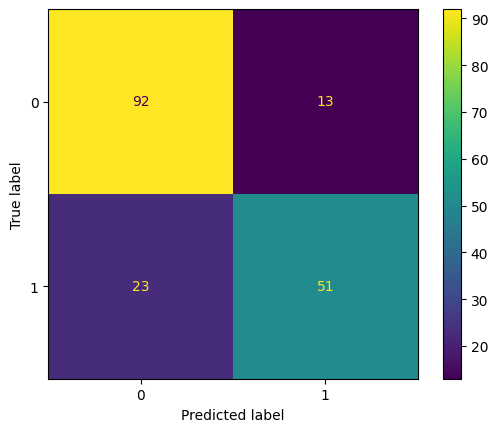

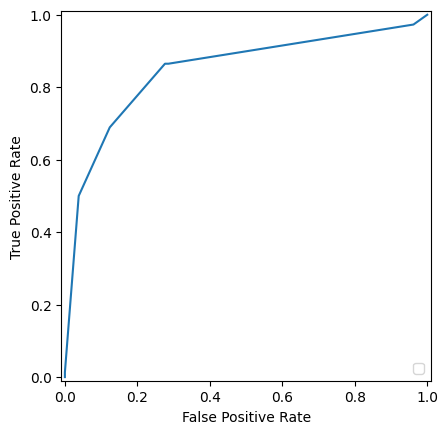

In [77]:
# Now i will evaluate the tuned Decision Tree classifier using confusion matrix, ROC curve, accuracy, and F1 score, as per the assignment:

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay

# Evaluate best model on test set
best_dt = grid.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best_dt)
ConfusionMatrixDisplay(cm).plot()

# ROC curve and AUC
y_proba = best_dt.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
print('ROC AUC:', roc_auc_score(y_test, y_proba))

# Accuracy and F1 score
print('Test accuracy:', accuracy_score(y_test, y_pred_best_dt))
print('Test F1 score:', f1_score(y_test, y_pred_best_dt))

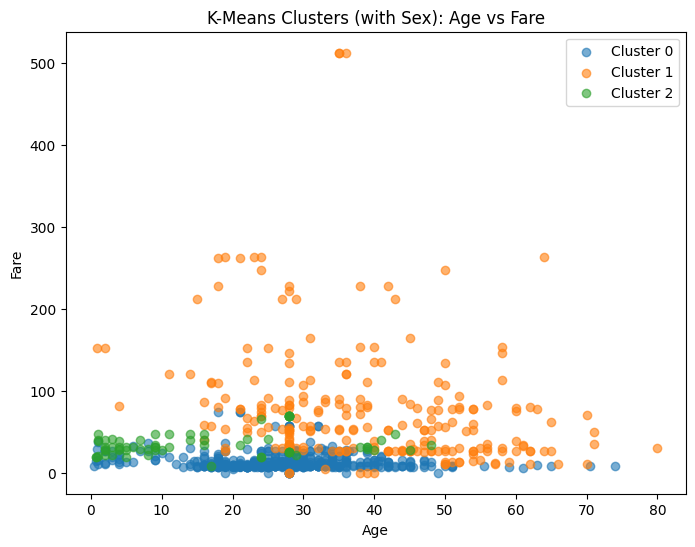

               Pclass  Sex        Age       Fare  FamilySize  Survived
Cluster_Sex                                                           
0            2.747405  0.0  26.976211  12.740224    1.442907  0.311419
1            1.121951  0.0  38.448862  76.921900    1.780488  0.593496
2            2.880597  0.0  16.574627  35.930039    6.343284  0.238806
Cluster_Sex
0    578
1    246
2     67
Name: count, dtype: int64


In [78]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select features for clustering
cluster_features = ['Pclass', 'Sex', 'Age', 'Fare', 'FamilySize']
X_cluster = df[cluster_features].copy()

# Need to fix these or it crashes
X_cluster['Sex'] = (X_cluster['Sex'] == 'male').astype(int)  # Overwrite with numeric encoding
df['Sex'] = (df['Sex'] == 'male').astype(int)  # Force sex to be numeric in df

# Standardize features for better clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Fit K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
df['Cluster_Sex'] = clusters

# Visualize clusters: Age vs Fare colored by cluster
plt.figure(figsize=(8,6))
for c in range(3):
    plt.scatter(df.loc[df['Cluster_Sex'] == c, 'Age'],
                df.loc[df['Cluster_Sex'] == c, 'Fare'],
                label=f'Cluster {c}', alpha=0.6)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('K-Means Clusters (with Sex): Age vs Fare')
plt.legend()
plt.show()

# Show cluster sizes and average feature values (including Sex)
print(df.groupby('Cluster_Sex')[cluster_features + ['Survived']].mean())
print(df['Cluster_Sex'].value_counts())

## Interpretation
The passenger groups show distinct patterns:

Cluster 0 (423 passengers):
  - Pclass: 2.75 (mostly 3rd class)
  - Sex: 1.00 (all male)
  - Age: 28.6
  - Fare: $12.46 (lowest)
  - FamilySize: 1.33 (mostly solo/small groups)
  - Survival Rate: 14%
  This cluster consists entirely of men, mostly in third class, traveling alone or in small groups, with the lowest fares and survival rate.

Cluster 1 (225 passengers):
  - Pclass: 1.04 (mostly 1st class)
  - Sex: 0.56 (mixed, majority female)
  - Age: 37.6 (oldest group)
  - Fare: $81.89 (highest)
  - FamilySize: 1.77 (small groups)
  - Survival Rate: 63%
This cluster is primarily first-class passengers, with a majority of women, older age, high fares, and the highest survival rate.

Cluster 2 (243 passengers):
  - Pclass: 2.70 (mostly 3rd class)
  - Sex: 0.12 (mostly female)
  - Age: 23.1 (youngest group)
  - Fare: $20.56 (mid-range)
  - FamilySize: 3.04 (larger families/groups)
  - Survival Rate: 58%
This cluster is mostly women and children in third class, traveling in larger families or groups, with moderate fares and a relatively high survival rate.

**Summary:**

Including Sex in clustering reveals that gender, class, and group size strongly influence survival. Men in third class had the lowest survival, while women and children—especially in first class or larger groups—had much better odds.

For the next step, we will implement Apriori to generate some more insights into our dataset: 

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
import pandas as pd

df_assoc = df.copy()
df_assoc['Sex'] = df_assoc['Sex'].map({1: 'Male', 0: 'Female'})
df_assoc['Pclass'] = df_assoc['Pclass'].map({1: '1st', 2: '2nd', 3: '3rd'})
df_assoc['Survived'] = df_assoc['Survived'].map({1: 'Survived', 0: 'Not Survived'})

# Age and fare binning
df_assoc['AgeBin'] = pd.cut(df_assoc['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
df_assoc['FareBin'] = pd.cut(df_assoc['Fare'], bins=[0, 20, 50, 100, 600], labels=['Low', 'Medium', 'High', 'Very High'])

# These are the features we will use
features = ['Sex', 'Pclass', 'Survived', 'AgeBin', 'FareBin']
df_apriori = pd.get_dummies(df_assoc[features])

# Find frequent itemsets
frequent_itemsets = apriori(df_apriori, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.2)
rules = rules.sort_values(by='lift', ascending=False)

# Display top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))

                                          antecedents  \
14                                       (Pclass_1st)   
15                                     (AgeBin_Adult)   
2                                        (Pclass_1st)   
3                                      (AgeBin_Adult)   
12                           (Sex_Female, Pclass_1st)   
13                         (Sex_Female, AgeBin_Adult)   
106              (Survived_Not Survived, FareBin_Low)   
123  (Survived_Not Survived, Sex_Female, FareBin_Low)   
131              (Survived_Not Survived, FareBin_Low)   
111                  (AgeBin_Young Adult, Pclass_3rd)   

                                      consequents   support  confidence  \
14                     (Sex_Female, AgeBin_Adult)  0.101010    0.416667   
15                       (Sex_Female, Pclass_1st)  0.101010    0.461538   
2                                  (AgeBin_Adult)  0.101010    0.416667   
3                                    (Pclass_1st)  0.101010    0.461538 

## Insights from Apriori

These are the most meaningful patterns revealed by Apriori:

- Passengers who survived are strongly associated with being female and traveling in 1st class.
(Survived) <=> (Sex: Female, Pclass: 1st)
High confidence and lift: Most 1st class women survived.

- Passengers who did not survive, paid low fares, and were young adult males in 3rd class are strongly associated.
(Survived: Not Survived, Fare: Low) <=> (Age: Young Adult, Sex: Male, Pclass: 3rd)
Indicates young men in 3rd class with low fares had poor survival odds.

- Young adult females are highly associated with survival.
(Sex: Female, Age: Young Adult) => (Survived)
(Survived, Age: Young Adult) => (Sex: Female)
Young women had much better survival rates than young men.

In summary, survival on the Titanic was most strongly linked to being female, traveling in 1st class, and being a young adult. On the other hand, young adult males in 3rd class with low fares were at greatest risk. These patterns confirm historical accounts and highlight the impact of gender, class, and age on survival.

## Applications and Conclusion
The association rules found in the Titanic dataset have practical implications. 

For example, insights about the impact of class, gender, and age on survival can guide the design of fairer and more effective safety policies.
Organizations can use these patterns to ensure equitable treatment and improve outcomes for all demographics.

The insights are also historically valuable: they validate traditional accounts and can be used to study the effects of social structures, biases, and policies on outcomes in many other contexts.
Researchers can apply similar methods to other datasets to uncover hidden relationships and inform public policy.

Data mining transforms raw data into actionable insights, helping organizations and policymakers make informed decisions, improve safety, and deliver better services by understanding the factors that influence outcomes.